In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob
import os
import shutil

import PIL
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from joblib import dump

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [ ]:
mask = glob.glob("/content/drive/My Drive/Mask_Detection/dataset/Mask/*.jpg")

image_list = []
image_list_ns = []
labels = []

wm = 'with_mask' #1 for with mask
wdm   = 'without_mask' #0 for with mask

for image in mask:
  
  image_list.append(np.array(Image.open(image).resize((224,224))))

  if wm in image.split('/')[-1].split('.')[0]:
    labels.append(1)
  elif wdm in image.split('/')[-1].split('.')[0]:
    labels.append(0)  

image_list_ns = np.asarray(image_list)

x = image_list_ns
y = np.array(labels)

In [ ]:
  #data split
def data_split(x,y,test_size):

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size,stratify = y ,random_state = 10)
    
    x_train = x_train / 255 #normalize the pixel
    x_val = x_val / 255 #normalize the pixel

    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_val: ", x_val.shape)
    print("y_val: ", y_val.shape)

    return x_train, x_val, y_train, y_val

In [ ]:
#getting the splitted data

x_train, x_val, y_train, y_val = data_split(x,y,test_size=0.2)

In [ ]:
datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='Nearest')

In [ ]:
model = MobileNetV2(input_shape=x_train[0].shape,include_top=False,weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
main_model = model.output
main_model = AveragePooling2D(pool_size=(7,7))(main_model)
main_model = Flatten(name='Flatten')(main_model)
main_model = Dense(128,activation='relu')(main_model)
main_model = Dropout(0.5)(main_model) #it prevent models from overfitting
main_model = Dense(1,activation='sigmoid')(main_model)

In [ ]:
models = Model(inputs=model.input,outputs=main_model)

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
models.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
models.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=3)
history = models.fit(x=x_train, y=y_train,batch_size=128,callbacks = es,epochs=70, verbose=1, validation_split=0.2)

Epoch 1/70
17/17 [==============================] - 4s 242ms/step - loss: 0.6718 - accuracy: 0.6442 - val_loss: 0.3355 - val_accuracy: 0.8973
Epoch 2/70
17/17 [==============================] - 3s 173ms/step - loss: 0.3211 - accuracy: 0.8803 - val_loss: 0.1763 - val_accuracy: 0.9632
Epoch 3/70
17/17 [==============================] - 3s 174ms/step - loss: 0.1950 - accuracy: 0.9365 - val_loss: 0.1185 - val_accuracy: 0.9748
Epoch 4/70
17/17 [==============================] - 3s 173ms/step - loss: 0.1424 - accuracy: 0.9544 - val_loss: 0.0932 - val_accuracy: 0.9806
Epoch 5/70
17/17 [==============================] - 3s 170ms/step - loss: 0.1063 - accuracy: 0.9733 - val_loss: 0.0798 - val_accuracy: 0.9864
Epoch 6/70
17/17 [==============================] - 3s 171ms/step - loss: 0.0916 - accuracy: 0.9670 - val_loss: 0.0724 - val_accuracy: 0.9845
Epoch 7/70
17/17 [==============================] - 3s 172ms/step - loss: 0.0829 - accuracy: 0.9733 - val_loss: 0.0658 - val_accuracy: 0.9884
Epoch 

In [ ]:
#evaluating the model
score = models.evaluate(x=x_val, y=y_val, verbose=1)

21/21 [==============================] - 1s 44ms/step - loss: 0.0180 - accuracy: 0.9938


In [ ]:
def plot_history(history,score):
  
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.savefig('Accuracy.png')

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.savefig('Loss.png')

Test Score: 0.018021177500486374
Test Accuracy: 0.9937984347343445


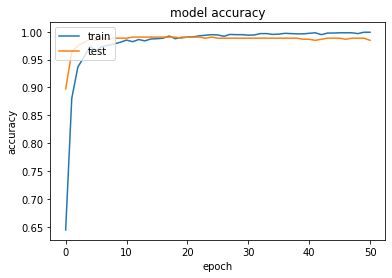

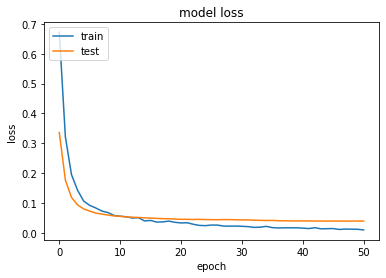

<Figure size 432x288 with 0 Axes>

In [ ]:
 #plotting the hostory
plot_history(history,score)

In [ ]:
models.save(filepath='/content/drive/My Drive/Mask_Detection/MobileNetV2',overwrite=True,save_format="h5")

In [ ]:
pr = models.predict(x_val)
pr = np.where(pr < 0.5, 0, 1)

print('\n Classification Report')
print(classification_report(y_val,pr))


 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       384
           1       0.99      1.00      0.99       261

    accuracy                           0.99       645
   macro avg       0.99      0.99      0.99       645
weighted avg       0.99      0.99      0.99       645

